In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from sklearn.metrics import f1_score , confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class Dense:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / (input_dim + output_dim)) # ensure tthe variance
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.output = None
        
    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        return self.output
    
    def backward(self, grad_output, learning_rate):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input

In [2]:
class BatchNorm:
    def __init__(self, input_dim, epsilon=1e-8, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))
        self.momentum = 0.9
        self.input = None
        self.normalized = None
        self.std = None
        self.var = None
        self.mean = None
        
    def forward(self, input_data, training=True):
        self.input = input_data
        
        if training:
            self.mean = np.mean(input_data, axis=0, keepdims=True)
            self.var = np.var(input_data, axis=0, keepdims=True)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.mean = self.running_mean
            self.var = self.running_var
        
        self.std = np.sqrt(self.var + self.epsilon)
        self.normalized = (input_data - self.mean) / self.std
        
        return self.gamma * self.normalized + self.beta
    
    def backward(self, grad_output, learning_rate):
        batch_size = grad_output.shape[0]
        
        grad_gamma = np.sum(grad_output * self.normalized, axis=0, keepdims=True)
        grad_beta = np.sum(grad_output, axis=0, keepdims=True)
        
        grad_normalized = grad_output * self.gamma
        grad_var = -0.5 * np.sum(grad_normalized * (self.input - self.mean) / (self.std ** 3), axis=0, keepdims=True)
        grad_mean = -np.sum(grad_normalized / self.std, axis=0, keepdims=True) - 2 * grad_var * np.mean(self.input - self.mean, axis=0, keepdims=True)
        grad_input = grad_normalized / self.std + 2 * grad_var * (self.input - self.mean) / batch_size + grad_mean / batch_size
        
        self.gamma -= learning_rate * grad_gamma
        self.beta -= learning_rate * grad_beta
        
        return grad_input

In [3]:
class ReLU:
    def __init__(self):
        self.input = None
        
    def forward(self, input_data):
        self.input = input_data
        return np.maximum(0, input_data)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Dropout:
    def __init__(self, drop_rate=0.5):
        self.drop_rate = drop_rate
        self.mask = None
        
    def forward(self, input_data, training=True):
        if training:
            self.mask = np.random.binomial(1, 1-self.drop_rate, size=input_data.shape) / (1-self.drop_rate)
            return input_data * self.mask
        return input_data
    
    def backward(self, grad_output):
        return grad_output * self.mask

In [4]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
        
    def update(self, params, grads):
        if not self.m:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
        
        self.t += 1
        
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            
            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [5]:
class Softmax:
    def __init__(self):
        self.output = None
        
    def forward(self, input_data):
        exp = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

In [6]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, num_classes, learning_rate=0.001,dropout_rate=0.3):
        self.layers = []
        layer_sizes = [input_size] + hidden_sizes + [num_classes]
        self.learning_rate = learning_rate
        
        # Create the network architecture
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Dense(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Don't add these layers after the last Dense layer
                self.layers.append(BatchNorm(layer_sizes[i+1]))
                self.layers.append(ReLU())
                self.layers.append(Dropout(dropout_rate))
        
        self.layers.append(Softmax())
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def forward(self, x, training=True):
        # Reshape input if necessary
        if len(x.shape) == 3:  # If input is (N, height, width)
            x = x.reshape(x.shape[0], -1)
        # Normalize input
        x = x.astype(np.float32) / 255.0
        
        output = x
        for layer in self.layers:
            if isinstance(layer, (BatchNorm, Dropout)):
                output = layer.forward(output, training)
            else:
                output = layer.forward(output)
        return output
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            if isinstance(layer, (Dense, BatchNorm)):
                grad_output = layer.backward(grad_output, self.optimizer.learning_rate)
            else:
                grad_output = layer.backward(grad_output)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
        # Convert labels to one-hot encoding
        enc = OneHotEncoder(sparse_output=False)
        y_train_oh = enc.fit_transform(y_train.reshape(-1, 1))
        y_val_oh = enc.transform(y_val.reshape(-1, 1))
        
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        val_f1s = []
        
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train = X_train[indices]
            y_train_oh = y_train_oh[indices]
            y_train = y_train[indices]  # Also shuffle original labels
            
            epoch_loss = 0
            correct_predictions = 0
            
            # Training
            for batch in tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{epochs}'):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size
                
                X_batch = X_train[start_idx:end_idx]
                y_batch_oh = y_train_oh[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx]
                
                # Forward pass
                output = self.forward(X_batch, training=True)
                predictions = np.argmax(output, axis=1)
                correct_predictions += np.sum(predictions == y_batch)
                
                # Calculate loss
                loss = -np.mean(np.sum(y_batch_oh * np.log(output + 1e-8), axis=1))
                epoch_loss += loss
                
                # Backward pass
                grad_output = output - y_batch_oh
                self.backward(grad_output)
            
            # Calculate training metrics
            train_loss = epoch_loss / n_batches
            train_acc = correct_predictions / n_samples
            
            # Validation metrics
            val_output = self.forward(X_val, training=False)
            val_loss = -np.mean(np.sum(y_val_oh * np.log(val_output + 1e-8), axis=1))
            val_pred = np.argmax(val_output, axis=1)
            val_acc = np.mean(val_pred == y_val)
            val_f1 = f1_score(y_val, val_pred, average='macro')
            
            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            print(f'Val Macro-F1: {val_f1:.4f}\n')
        
        return train_losses, val_losses, train_accs, val_accs, val_f1s

In [7]:
def load_and_preprocess_data(validation_split=0.1, random_seed=42):
    """
    Load and preprocess Fashion MNIST dataset with proper normalization and validation split.
    
    Parameters:
        validation_split (float): Proportion of training data to use for validation
        random_seed (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Load the data
    transform = transforms.ToTensor()
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    # Convert to numpy arrays
    X_train = train_dataset.data.numpy()
    y_train = train_dataset.targets.numpy()
    X_test = test_dataset.data.numpy()
    y_test = test_dataset.targets.numpy()
    
    # Reshape the data
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten 28x28 to 784
    X_test = X_test.reshape(X_test.shape[0], -1)     # Flatten 28x28 to 784
    
    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float32))
    X_test = scaler.transform(X_test.astype(np.float32))
    
    # Create validation split
    n_train = X_train.shape[0]
    indices = np.random.permutation(n_train)
    n_val = int(validation_split * n_train)
    train_indices, val_indices = indices[n_val:], indices[:n_val]
    
    # Split the data
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]
    
    # Print dataset information
    print("Dataset shapes:")
    print(f"Training set: {X_train.shape} with labels {y_train.shape}")
    print(f"Validation set: {X_val.shape} with labels {y_val.shape}")
    print(f"Test set: {X_test.shape} with labels {y_test.shape}")
    
    # Print class distribution
    print("\nClass distribution:")
    print("Training set:")
    for i in range(10):
        count = np.sum(y_train == i)
        percentage = count / len(y_train) * 100
        print(f"Class {i}: {count} samples ({percentage:.1f}%)")
    
    return X_train, y_train, X_val, y_val, X_test, y_test


    

In [8]:
def plot_confusion_matrix(conf_matrix, class_names=None):
    """
    Plot confusion matrix with a heatmap.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    
    # Add labels
    if class_names is None:
        class_names = [str(i) for i in range(conf_matrix.shape[0])]
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def plot_per_class_metrics(per_class_acc, per_class_f1, class_names=None):
    """
    Plot per-class accuracy and F1-scores.
    """
    if class_names is None:
        class_names = [str(i) for i in range(len(per_class_acc))]
    
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, per_class_acc, width, label='Accuracy')
    rects2 = ax.bar(x + width/2, per_class_f1, width, label='F1-score')
    
    ax.set_ylabel('Score')
    ax.set_title('Per-class Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, val_f1s):
    epochs = len(train_losses)
    
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Plot F1 scores
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epoch')
    plt.ylabel('Macro-F1 Score')
    plt.legend()
    plt.title('Validation Macro-F1 Score')
    
    plt.tight_layout()
    plt.show()

Loading data...
Dataset shapes:
Training set: (54000, 784) with labels (54000,)
Validation set: (6000, 784) with labels (6000,)
Test set: (10000, 784) with labels (10000,)

Class distribution:
Training set:
Class 0: 5403 samples (10.0%)
Class 1: 5392 samples (10.0%)
Class 2: 5389 samples (10.0%)
Class 3: 5413 samples (10.0%)
Class 4: 5373 samples (10.0%)
Class 5: 5379 samples (10.0%)
Class 6: 5381 samples (10.0%)
Class 7: 5450 samples (10.1%)
Class 8: 5410 samples (10.0%)
Class 9: 5410 samples (10.0%)
Initializing model...
Training model...


Epoch 1/10: 100%|██████████| 843/843 [00:12<00:00, 64.99it/s]


Epoch 1/10:
Train Loss: 1.2284, Train Accuracy: 0.6087
Val Loss: 0.6411, Val Accuracy: 0.7910
Val Macro-F1: 0.7850



Epoch 2/10: 100%|██████████| 843/843 [00:15<00:00, 55.11it/s] 


Epoch 2/10:
Train Loss: 0.7515, Train Accuracy: 0.7606
Val Loss: 0.5171, Val Accuracy: 0.8177
Val Macro-F1: 0.8176



Epoch 3/10: 100%|██████████| 843/843 [00:22<00:00, 37.28it/s]


Epoch 3/10:
Train Loss: 0.6554, Train Accuracy: 0.7873
Val Loss: 0.4699, Val Accuracy: 0.8325
Val Macro-F1: 0.8323



Epoch 4/10: 100%|██████████| 843/843 [00:16<00:00, 51.94it/s] 


Epoch 4/10:
Train Loss: 0.6077, Train Accuracy: 0.8021
Val Loss: 0.4434, Val Accuracy: 0.8442
Val Macro-F1: 0.8435



Epoch 5/10: 100%|██████████| 843/843 [00:09<00:00, 92.23it/s] 


Epoch 5/10:
Train Loss: 0.5676, Train Accuracy: 0.8134
Val Loss: 0.4217, Val Accuracy: 0.8517
Val Macro-F1: 0.8522



Epoch 6/10: 100%|██████████| 843/843 [00:40<00:00, 20.93it/s]


Epoch 6/10:
Train Loss: 0.5464, Train Accuracy: 0.8200
Val Loss: 0.4091, Val Accuracy: 0.8560
Val Macro-F1: 0.8561



Epoch 7/10: 100%|██████████| 843/843 [00:25<00:00, 33.47it/s]


Epoch 7/10:
Train Loss: 0.5272, Train Accuracy: 0.8265
Val Loss: 0.3992, Val Accuracy: 0.8577
Val Macro-F1: 0.8578



Epoch 8/10: 100%|██████████| 843/843 [00:33<00:00, 25.43it/s]


Epoch 8/10:
Train Loss: 0.5144, Train Accuracy: 0.8309
Val Loss: 0.3964, Val Accuracy: 0.8633
Val Macro-F1: 0.8631



Epoch 9/10: 100%|██████████| 843/843 [00:23<00:00, 36.36it/s]


Epoch 9/10:
Train Loss: 0.4956, Train Accuracy: 0.8359
Val Loss: 0.3842, Val Accuracy: 0.8662
Val Macro-F1: 0.8672



Epoch 10/10: 100%|██████████| 843/843 [00:19<00:00, 43.42it/s]


Epoch 10/10:
Train Loss: 0.4855, Train Accuracy: 0.8405
Val Loss: 0.3824, Val Accuracy: 0.8658
Val Macro-F1: 0.8663


Evaluating on test set...

=== Test Set Results ===
Test Loss: 0.4087
Test Accuracy: 0.8591
Test Macro-F1: 0.8581

Per-class Performance:
Class		Accuracy	F1-Score
--------------------------------------------------
T-shirt/top     0.8490	0.8175
Trouser         0.9540	0.9705
Pullover        0.7690	0.7721
Dress           0.8790	0.8660
Coat            0.7860	0.7763
Sandal          0.9130	0.9316
Shirt           0.6050	0.6429
Sneaker         0.9370	0.9164
Bag             0.9600	0.9524
Ankle boot      0.9390	0.9357

Generating visualization plots...


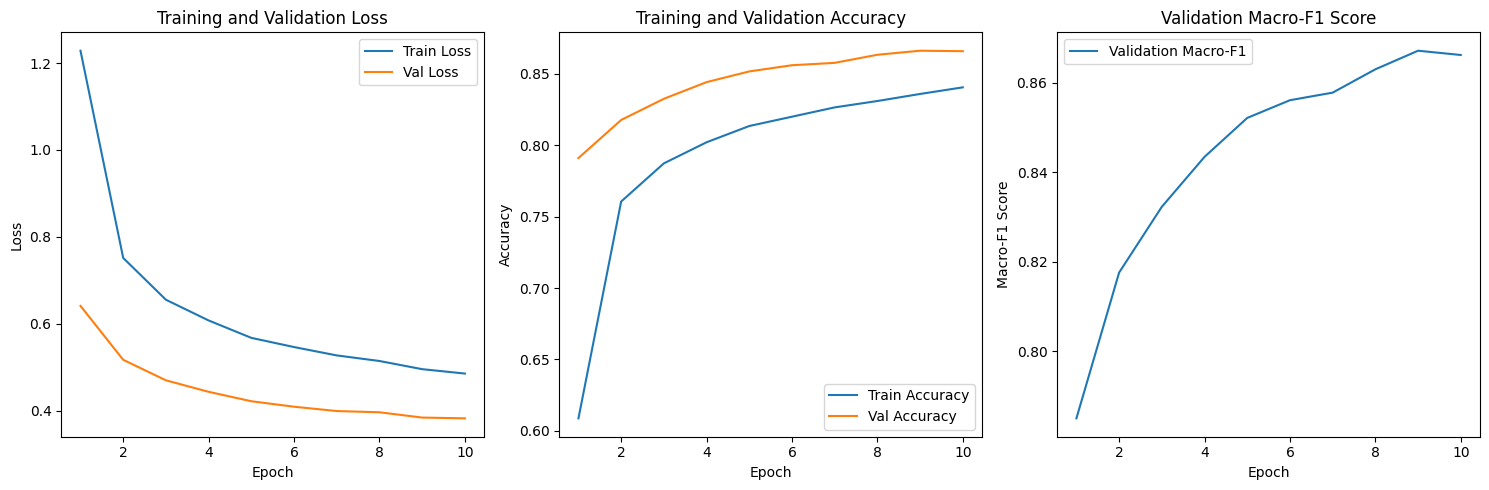

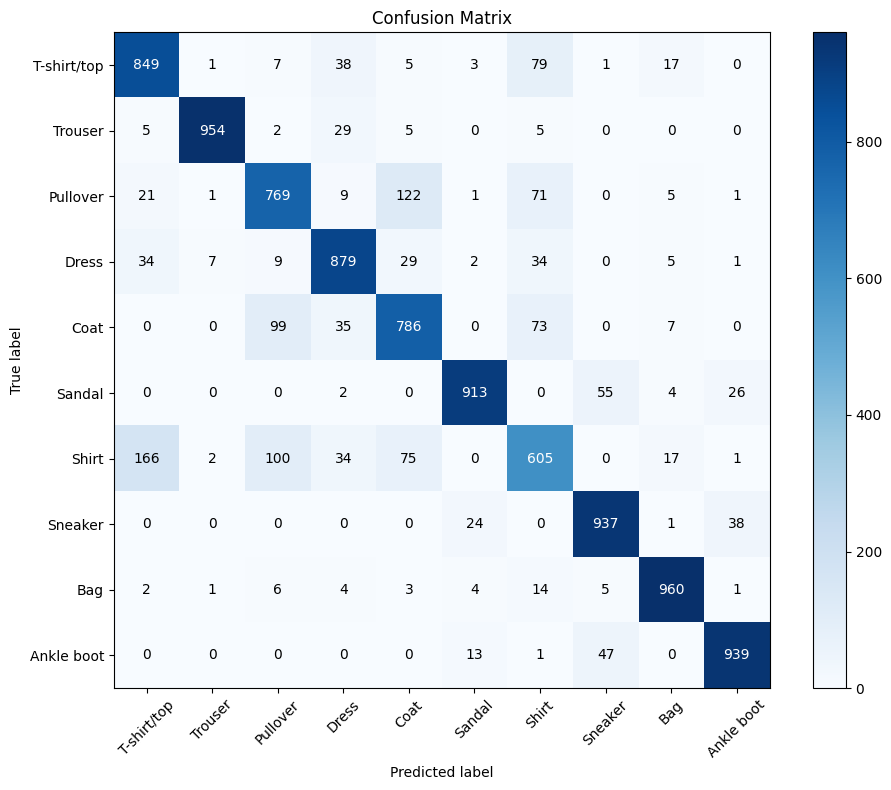

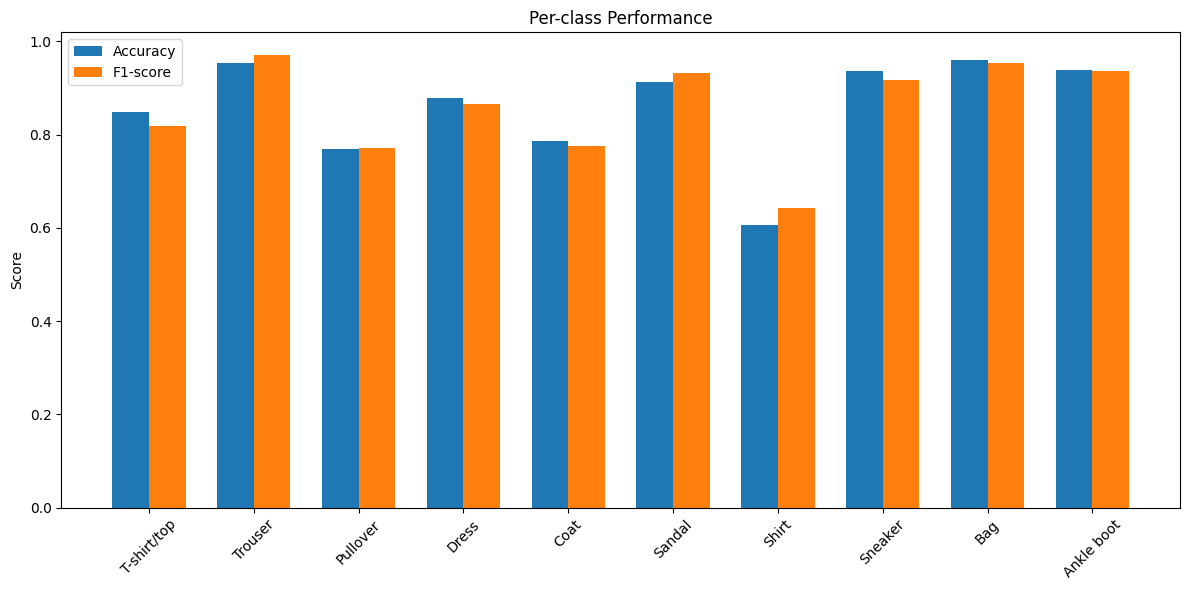


Saving results to 'model_results.txt'...

Evaluation complete!


In [10]:
def main():
    # Fashion MNIST class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    print("Loading data...")
    x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_data()
    
    # Initialize model
    input_size = 784  # 28x28 pixels
    hidden_sizes = [256, 128, 64]
    num_classes = 10
    learning_rate = 0.001
    
    print("Initializing model...")
    model = NeuralNetwork(input_size, hidden_sizes, num_classes, learning_rate)
    
    print("Training model...")
    metrics = model.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=64)
    
    # Create encoder for test set evaluation
    print("\nEvaluating on test set...")
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(y_train.reshape(-1, 1))  # Fit on training data
    
    # Test set evaluation
    predictions = model.forward(x_test, training=False)
    test_pred = np.argmax(predictions, axis=1)
    
    # Calculate overall metrics
    test_acc = np.mean(test_pred == y_test)
    test_macro_f1 = f1_score(y_test, test_pred, average='macro')
    test_loss = -np.mean(np.sum(enc.transform(y_test.reshape(-1, 1)) * 
                               np.log(predictions + 1e-8), axis=1))
    
    # Print overall results
    print("\n=== Test Set Results ===")
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Macro-F1: {test_macro_f1:.4f}')
    
    # Calculate per-class metrics
    per_class_acc = []
    per_class_f1 = f1_score(y_test, test_pred, average=None)
    conf_matrix = confusion_matrix(y_test, test_pred)
    
    # Print per-class performance
    print("\nPer-class Performance:")
    print("Class\t\tAccuracy\tF1-Score")
    print("-" * 50)
    for class_idx in range(num_classes):
        class_mask = y_test == class_idx
        class_acc = np.mean(test_pred[class_mask] == y_test[class_mask])
        per_class_acc.append(class_acc)
        print(f"{class_names[class_idx]:<15} {class_acc:.4f}\t{per_class_f1[class_idx]:.4f}")
    
    # Plot results
    print("\nGenerating visualization plots...")
    plot_metrics(*metrics)
    plot_confusion_matrix(conf_matrix, class_names)
    plot_per_class_metrics(per_class_acc, per_class_f1, class_names)
    
    # Save results to file
    print("\nSaving results to 'model_results.txt'...")
    with open('model_results.txt', 'w') as f:
        f.write("=== Model Configuration ===\n")
        f.write(f"Hidden layers: {hidden_sizes}\n")
        f.write(f"Learning rate: {learning_rate}\n\n")
        
        f.write("=== Test Set Results ===\n")
        f.write(f'Test Loss: {test_loss:.4f}\n')
        f.write(f'Test Accuracy: {test_acc:.4f}\n')
        f.write(f'Test Macro-F1: {test_macro_f1:.4f}\n\n')
        
        f.write("=== Per-class Performance ===\n")
        for i in range(num_classes):
            f.write(f"{class_names[i]:<15} Acc: {per_class_acc[i]:.4f} F1: {per_class_f1[i]:.4f}\n")
    
    print("\nEvaluation complete!")

if __name__ == "__main__":
    main()